# LSTM-ISTA introduction and guide
## Import components: Keras, SciPy input/output, Numpy, Time, and Visualization with Python.

In [2]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend
from tensorflow.keras.initializers import Constant
import scipy.io as sio
import numpy as np
import time
import matplotlib.pyplot as plt

## Build up architecture of LSTM-ISTA, corresponding loss functions, and training methods.

In [33]:
class LSTM_ISTA():
    def __init__(self):
        optimizer1 = Adam(learning_rate=2.3e-3)
        optimizer2 = Adam(learning_rate=1e-3)
        self.LSTM_denoise_model = self.LSTM_denoise()
        self.LSTM_seg_model = self.LSTM_seg()
        self.LSTM_trace_model = self.LSTM_trace()
        self.LSTM_ISTAseg_model = self.LSTM_ISTAseg()
        self.LSTM_ISTAnet_model = self.LSTM_ISTAnet()
        
        
        def seg_loss(y_true, y_pred):
            smooth = 1e-6
            regularized_loss = backend.sum(backend.square(y_pred[:,:,:,:,0] - y_true[:,0:1000,:,:,0])) + 0.01*backend.sum(backend.square(y_pred[:,:,:,:,16]))
            intersection = backend.sum(backend.permute_dimensions(y_true[:,1000:1015,:,:,0],pattern=(0,2,3,1)) * backend.max(y_pred[:,:,:,:,17:32],axis=1,keepdims=False))
            union = backend.sum(backend.permute_dimensions(y_true[:,1000:1015,:,:,0],pattern=(0,2,3,1)) + backend.max(y_pred[:,:,:,:,17:32],axis=1,keepdims=False))
            dice_loss = 1-backend.mean((2. * intersection + smooth)/(union + smooth))
            return 0.1*regularized_loss + dice_loss

        def pearson_correlation_loss(y_true, y_pred):
            pearson_correlation_loss = backend.sum((y_pred-backend.mean(y_pred))*(y_true-backend.mean(y_true))) / backend.sqrt(backend.sum(backend.square(y_pred-backend.mean(y_pred)))*backend.sum(backend.square((y_true-backend.mean(y_true)))))
            pearson_correlation_loss = 1 - pearson_correlation_loss
            return pearson_correlation_loss
        
        self.LSTM_ISTAseg_model.compile_metrics = None
        self.LSTM_ISTAnet_model.compile_metrics = None
        self.LSTM_ISTAseg_model.compile(loss=seg_loss, optimizer=optimizer1)
        self.LSTM_ISTAnet_model.compile(loss=pearson_correlation_loss, optimizer=optimizer2)
        
        

    def LSTM_denoise(self):
        N = 15
        inputs = Input(shape=(1000,64,64,1))
        #x0 = Conv3D(1, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')(inputs)
        #res1 = Conv3D(1,1,padding='same',kernel_initializer = Constant(value=0.01))(subtract([x0,x0]))
        R1 = inputs # r1
        conv1_1 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(R1)                
        f11 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv1_2 = f11(R1)
        conv1_symm = f11(R1)
        f12 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv1_3 = f12(conv1_2)
        conv1_symm = f12(conv1_symm)
        temp = 0.01
        conv1_4 = multiply([Lambda(lambda x: backend.sign(x))(conv1_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv1_3)))])
        f13 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv1_5 = f13(conv1_4)
        conv1_symm = f13(conv1_symm)
        f14 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv1_6 = f14(conv1_5)       
        conv1_symm = f14(conv1_symm)       
        conv1_7 = Conv3D(1, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(conv1_6)                
        conv1_7 = add([conv1_7, R1])
        conv1_8 = subtract([conv1_symm, conv1_1])

        temp = 0.01
        R2 = subtract([conv1_7, Lambda(lambda x: temp*x)(subtract([conv1_7,inputs]))]) # r2
        conv2_1 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(R2)                
        f21 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv2_2 = f21(conv2_1)
        conv2_symm = f21(conv2_1)
        f22 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv2_3 = f22(conv2_2)
        conv2_symm = f22(conv2_symm)
        temp = 0.01
        conv2_4 = multiply([Lambda(lambda x: backend.sign(x))(conv2_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv2_3)))])
        f23 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv2_5 = f23(conv2_4)
        conv2_symm = f23(conv2_symm)
        f24 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv2_6 = f24(conv2_5)       
        conv2_symm = f24(conv2_symm)       
        conv2_7 = Conv3D(1, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(conv2_6)                
        conv2_7 = add([conv2_7, R2])
        conv2_8 = subtract([conv2_symm, conv2_1])

        R3 = subtract([conv2_7, Lambda(lambda x: temp*x)(subtract([conv2_7,inputs]))]) # r3
        conv3_1 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(R3)
        f31 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv3_2 = f31(conv3_1)
        conv3_symm = f31(conv3_1)
        f32 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv3_3 = f32(conv3_2)
        conv3_symm = f32(conv3_symm)
        temp = 0.01
        conv3_4 = multiply([Lambda(lambda x: backend.sign(x))(conv3_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv3_3)))])
        f33 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv3_5 = f33(conv3_4)
        conv3_symm = f33(conv3_symm)
        f34 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv3_6 = f34(conv3_5)       
        conv3_symm = f34(conv3_symm)       
        conv3_7 = Conv3D(1, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(conv3_6)                
        conv3_7 = add([conv3_7, R3])
        conv3_8 = subtract([conv3_symm, conv3_1])

        R4 = subtract([conv3_7, Lambda(lambda x: temp*x)(subtract([conv3_7,inputs]))]) # r4
        conv4_1 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(R4)                
        f41 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv4_2 = f41(conv4_1)
        conv4_symm = f41(conv4_1)
        f42 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv4_3 = f42(conv4_2)
        conv4_symm = f42(conv4_symm)
        temp = 0.01
        conv4_4 = multiply([Lambda(lambda x: backend.sign(x))(conv4_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv4_3)))])
        f43 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv4_5 = f43(conv4_4)
        conv4_symm = f43(conv4_symm)
        f44 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv4_6 = f44(conv4_5)       
        conv4_symm = f44(conv4_symm)       
        conv4_7 = Conv3D(1, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(conv4_6)                
        conv4_7 = add([conv4_7, R4])
        conv4_8 = subtract([conv4_symm, conv4_1])

        R5 = subtract([conv4_7, Lambda(lambda x: temp*x)(subtract([conv4_7,inputs]))]) # r5
        conv5_1 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(R5)
        f51 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv5_2 = f51(conv5_1)
        conv5_symm = f51(conv5_1)
        f52 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv5_3 = f52(conv5_2)
        conv5_symm = f52(conv5_symm)
        temp = 0.01
        conv5_4 = multiply([Lambda(lambda x: backend.sign(x))(conv5_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv5_3)))])
        f53 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv5_5 = f53(conv5_4)
        conv5_symm = f53(conv5_symm)
        f54 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv5_6 = f54(conv5_5)       
        conv5_symm = f54(conv5_symm)       
        conv5_7 = Conv3D(1, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(conv5_6)                
        conv5_7 = add([conv5_7, R5])
        conv5_8 = subtract([conv5_symm, conv5_1])
        
        R6 = subtract([conv5_7, Lambda(lambda x: temp*x)(subtract([conv5_7,inputs]))])   # r6
        conv6_1 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(R6)
        f61 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv6_2 = f61(conv6_1)
        conv6_symm = f61(conv6_1)
        f62 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv6_3 = f62(conv6_2)
        conv6_symm = f62(conv6_symm)
        temp = 0.01
        conv6_4 = multiply([Lambda(lambda x: backend.sign(x))(conv6_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv6_3)))])
        f63 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv6_5 = f63(conv6_4)
        conv6_symm = f63(conv6_symm)
        f64 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv6_6 = f64(conv6_5)       
        conv6_symm = f64(conv6_symm)       
        conv6_7 = Conv3D(1, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(conv6_6)                
        conv6_7 = add([conv6_7, R6])
        conv6_8 = subtract([conv6_symm, conv6_1])

        R7 = subtract([conv6_7, Lambda(lambda x: temp*x)(subtract([conv6_7,inputs]))]) # r7
        conv7_1 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(R7)
        f71 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv7_2 = f71(conv7_1)
        conv7_symm = f71(conv7_1)
        f72 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv7_3 = f72(conv7_2)
        conv7_symm = f72(conv7_symm)
        temp = 0.01
        conv7_4 = multiply([Lambda(lambda x: backend.sign(x))(conv7_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv7_3)))])
        f73 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv7_5 = f73(conv7_4)
        conv7_symm = f73(conv7_symm)
        f74 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv7_6 = f74(conv7_5)       
        conv7_symm = f74(conv7_symm)       
        conv7_7 = Conv3D(1, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(conv7_6)                
        conv7_7 = add([conv7_7, R7])
        conv7_8 = subtract([conv7_symm, conv7_1])
        
        R8 = subtract([conv7_7, Lambda(lambda x: temp*x)(subtract([conv7_7,inputs]))]) # r8
        conv8_1 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(R8)
        f81 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv8_2 = f81(conv8_1)
        conv8_symm = f81(conv8_1)
        f82 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv8_3 = f82(conv8_2)
        conv8_symm = f82(conv8_symm)
        temp = 0.01
        conv8_4 = multiply([Lambda(lambda x: backend.sign(x))(conv8_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv8_3)))])
        f83 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv8_5 = f83(conv8_4)
        conv8_symm = f83(conv8_symm)
        f84 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv8_6 = f84(conv8_5)       
        conv8_symm = f84(conv8_symm)       
        conv8_7 = Conv3D(1, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(conv8_6)                
        conv8_7 = add([conv8_7, R8])
        conv8_8 = subtract([conv8_symm, conv8_1])

        R9 = subtract([conv8_7, Lambda(lambda x: temp*x)(subtract([conv8_7,inputs]))]) # r9
        conv9_1 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(R9)
        f91 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv9_2 = f91(conv9_1)
        conv9_symm = f91(conv9_1)
        f92 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv9_3 = f92(conv9_2)
        conv9_symm = f92(conv9_symm)
        temp = 0.01
        conv9_4 = multiply([Lambda(lambda x: backend.sign(x))(conv9_3), ReLU()(Lambda(lambda x: x-temp)(Lambda(lambda x: backend.abs(x))(conv9_3)))])
        f93 = Conv3D(15, (1,3,3), activation = 'relu', padding = 'same', data_format='channels_last')
        conv9_5 = f93(conv9_4)
        conv9_symm = f93(conv9_symm)
        f94 = Conv3D(15, (1,3,3), activation = None, padding = 'same', data_format='channels_last')
        conv9_6 = f94(conv9_5)       
        conv9_symm = f94(conv9_symm)       
        conv9_7 = Conv3D(1, (1,3,3), activation = None, padding = 'same', data_format='channels_last')(conv9_6)                
        conv9_7 = add([conv9_7, R9])
        conv9_8 = subtract([conv9_symm, conv9_1])
        
        output_symm = conv1_8
        output_symm = Add()([output_symm, conv2_8])
        output_symm = Add()([output_symm, conv3_8])
        output_symm = Add()([output_symm, conv4_8])
        output_symm = Add()([output_symm, conv5_8])
        output_symm = Add()([output_symm, conv6_8])
        output_symm = Add()([output_symm, conv7_8])
        output_symm = Add()([output_symm, conv8_8])
        output_symm = Add()([output_symm, conv9_8])
        output_symm = Lambda(lambda x: backend.mean(x,axis=4,keepdims=True)/9)(output_symm)
        
        outputs = Concatenate(axis = 4)([conv9_7, conv9_4, output_symm]) # (?,1000,64,64,1+15+1+1)
        print('****************ISTA*****************',outputs)
        return Model(inputs = inputs, outputs = outputs)
    def LSTM_seg(self):
        inputs = Input(shape=(1000,64,64,17))
        data = Lambda(lambda x: x[:,:,:,:,1:16])(inputs)
        #segs1 =  Conv3D(15, (3,3,3), activation = 'relu', padding = 'same', data_format='channels_last')(data) 
        segs = ConvLSTM2D(15,3, padding='same',activation="relu",recurrent_activation="sigmoid",return_sequences=True)(data)
        #segs =  Conv3D(15, (3,3,3), activation = 'hard_sigmoid', padding = 'same', data_format='channels_last')(segs1) 
        segs = CFF(segs)
        outputs = Concatenate(axis = 4)([inputs, segs]) # (?,1000,64,64,1+15+1+15)
        print('****************LSTM_seg*****************',outputs)
        return Model(inputs = inputs, outputs = outputs)
    
    def LSTM_trace(self):
        inputs = Input(shape=(1000,64,64,32))
        video = Lambda(lambda x: x[:,:,:,:,0])(inputs)
        video = Reshape((1000,64,64,1))(video)
        masks = Lambda(lambda x: x[:,:,:,:,17:32])(inputs)
        video_15 = video
        for i in range(14):
            video_15 = Concatenate(axis=4)([video_15,video])
        trace1 = multiply([video_15, masks])
        trace1 = TimeDistributed(GlobalAveragePooling2D())(trace1) 
        trace2 = Conv1D(64,3,activation = 'relu', padding = 'same')(trace1)
        trace3 = Conv1D(32,3,activation = 'relu', padding = 'same')(trace2)
        trace4 = Conv1D(15,3,activation = 'relu', padding = 'same')(trace3) # (?,1000,15)
        #outputs = Lambda(lambda x: backend.abs(x))(trace4)
        print('****************LSTM_trace*****************',trace4)
        return Model(inputs = inputs, outputs = trace4)
    
    def LSTM_ISTAseg(self):
        #self.LSTM_denoise_model.trainable = False
        model = Sequential()
        model.add(self.LSTM_denoise_model)
        model.add(self.LSTM_seg_model)
        model.summary()
        return model
    
    def LSTM_ISTAnet(self):
        self.LSTM_ISTAseg_model.trainable = False
        model = Sequential()
        model.add(self.LSTM_ISTAseg_model)
        model.add(self.LSTM_trace_model)
        model.summary()
        return model
            
    def train_seg(self, video, data, seg_GT, epoch, iteration, batch_size):
        start_time = time.time()
        # Size of "video" and "data" is (?,1000,64,64,1) 
        # Size of seg_GT is (?,64,64,15)
        seg_GT = np.expand_dims(np.transpose(seg_GT,[0,3,1,2]), axis=4) # (?,15,64,64,1)
        GT = np.concatenate((data,seg_GT),axis=1) # (?,1015,64,64,1)
        loss_seg = self.LSTM_ISTAseg_model.train_on_batch(video, GT)
        print('Epoch: ',epoch+1, '/15, Iteration: ', iteration+1, '/', int(2000/batch_size),', Loss_seg: ',loss_seg)        
        if iteration % 10 == 0:
            mask = self.LSTM_ISTAseg_model.predict_on_batch(np.expand_dims(video[0], axis=0))
            img_denoised = mask[0,:,:,:,0]
            img_denoised = np.amax(img_denoised,axis=0)
            img_sparse = mask[0,:,:,:,1:16]
            img_sparse = np.amax(np.amax(img_sparse,axis=0),axis=2)
            img_GT = data[0,:,:,:,0]
            img_GT = np.amax(img_GT,axis=0)
            img_raw = video[0,:,:,:,0]
            img_raw = np.amax(img_raw,axis=0)
            mask = mask[0,:,:,:,17:32]
            mask = np.amax(mask,axis=0)
            GT = np.squeeze(seg_GT[0])
            plt.figure(figsize=(8,4))
            plt.subplot(1,4,1)
            plt.imshow(img_raw,vmin=0,vmax=1,cmap='gray')
            plt.axis('off')  
            plt.title('Raw measurements')
            plt.subplot(1,4,2)
            plt.imshow(img_GT,vmin=0,vmax=1,cmap='gray')
            plt.axis('off')  
            plt.title('Ground Truth')
            plt.subplot(1,4,3)
            plt.imshow(img_denoised,vmin=0,vmax=1,cmap='gray')            
            plt.axis('off')
            plt.title('Denoised video')
            plt.subplot(1,4,4)
            plt.imshow(img_sparse,vmin=-0.25,vmax=0.25,cmap='gray')
            plt.axis('off')  
            plt.title('Sparse Representation')
            plt.show()
            
            
            plt.figure(figsize=(15,3))
            for i in range(15):
                plt.subplot(2,15,i+1)
                plt.imshow(mask[:,:,i],vmin=0,vmax=1,cmap='gray')
                plt.axis('off')
                plt.title('#'+str(i+1))
                plt.subplot(2,15,i+16)
                plt.imshow(GT[i,:,:],vmin=0,vmax=1,cmap='gray')
                plt.axis('off')
            plt.suptitle('Segmentation results')
            plt.show()
            del(img_GT)
            del(img_denoised)
            del(img_sparse)
            del(GT)
            del(mask)
        if iteration % (int(8748/batch_size)-1) == 0:
            self.LSTM_ISTAseg_model.save('LSTM_seg.h5')
        print("--- %s seconds escaped ---" % (time.time() - start_time))
    def train_trace(self, video, trace_GT, epoch, iteration, batch_size):
        start_time = time.time()
        #trace_GT = np.expand_dims(seg_GT, axis=1)
        loss_trace = self.LSTM_ISTAnet_model.train_on_batch(video, trace_GT)
        print('Epoch: ',epoch+1, '/15, Iteration: ', iteration+1, '/', int(2000/batch_size),', loss_trace', loss_trace)
        if iteration % 10 == 0:
            
            trace = self.LSTM_ISTAnet_model.predict_on_batch(np.expand_dims(video[0], axis=0))
            trace = np.squeeze(trace[0])
            GT = np.squeeze(trace_GT[0])
            plt.figure(figsize=(15, 3))
            for i in range(15):
                plt.title('#'+str(i+1))
                plt.subplot(2,15,i+1)
                plt.plot(trace[:,i])
                plt.axis('off')                
                plt.subplot(2,15,i+16)
                plt.plot(GT[:,i])
                plt.axis('off')
            plt.suptitle('Traces results')
            plt.show()
            del(GT)
            del(trace)
        if iteration % (int(8748/batch_size)-1) == 0:
            self.LSTM_ISTAnet_model.save('LSTM_ISTAnet.h5')
        print("--- %s seconds escaped ---" % (time.time() - start_time))

## Load training dataset, and set hyper-parameters including number of epoch and batch size.

In [34]:
N_epoch = 10
batch_size = 4
model = LSTM_ISTA()

for i in range(N_epoch): # epoch
    index = np.random.permutation(81*15*6) + 1
    index = index[0:2000]
    for j in range(int(2000/batch_size)): # iteration
        index_batch = index[j*batch_size:(j+1)*batch_size]
        LSTM_Video = sio.loadmat('./LSTM_Dataset/Train/LSTM_Video_'+str(index_batch[0])+'.mat')
        LSTM_Video = LSTM_Video['LSTM_video']
        LSTM_Video = np.transpose(LSTM_Video,[2,0,1])
        LSTM_Video = np.expand_dims(np.expand_dims(LSTM_Video,3),0)

        LSTM_Data = sio.loadmat('./LSTM_Dataset/Train/LSTM_Data_'+str(index_batch[0])+'.mat')
        LSTM_Data = LSTM_Data['LSTM_data']
        LSTM_Data = np.transpose(LSTM_Data,[2,0,1])
        LSTM_Data = np.expand_dims(np.expand_dims(LSTM_Data,3),0)

        LSTM_Masks = sio.loadmat('./LSTM_Dataset/Train/LSTM_Masks_'+str(index_batch[0])+'.mat')
        LSTM_Masks = LSTM_Masks['LSTM_mask']
        LSTM_Masks = np.float32(np.expand_dims(LSTM_Masks,0))

        LSTM_Trace = sio.loadmat('./LSTM_Dataset/Train/LSTM_Trace_'+str(index_batch[0])+'.mat')
        LSTM_Trace = LSTM_Trace['LSTM_trace']
        LSTM_Trace = np.transpose(LSTM_Trace,[1,0])
        LSTM_Trace = np.expand_dims(LSTM_Trace,0)


        for k in range(batch_size-1): # load in batchsize
            Video = sio.loadmat('./LSTM_Dataset/Train/LSTM_Video_'+str(index_batch[k])+'.mat')
            Video = Video['LSTM_video']
            Video = np.transpose(Video,[2,0,1])
            LSTM_Video = np.append(LSTM_Video, np.expand_dims(np.expand_dims(Video,3),0), axis = 0)

            Data = sio.loadmat('./LSTM_Dataset/Train/LSTM_Data_'+str(index_batch[k])+'.mat')
            Data = Data['LSTM_data']
            Data = np.transpose(Data,[2,0,1])
            LSTM_Data = np.append(LSTM_Data, np.expand_dims(np.expand_dims(Data,3),0), axis = 0)

            Masks = sio.loadmat('./LSTM_Dataset/Train/LSTM_Masks_'+str(index_batch[k])+'.mat')
            Masks = np.float32(Masks['LSTM_mask'])
            LSTM_Masks = np.append(LSTM_Masks, np.expand_dims(Masks,0), axis = 0)

            Trace = sio.loadmat('./LSTM_Dataset/Train/LSTM_Trace_'+str(index_batch[k])+'.mat')
            Trace = Trace['LSTM_trace']
            Trace = np.transpose(Trace,[1,0])
            LSTM_Trace = np.append(LSTM_Trace, np.expand_dims(Trace,0), axis = 0)
            del(Video)
            del(Masks)
            del(Trace)
            del(Data)
        model.train_seg(LSTM_Video, LSTM_Data, LSTM_Masks, i, j, batch_size)
        if i > int(N_epoch*2/3)-1:
            model.train_trace(LSTM_Video, LSTM_Trace, i, j, batch_size)
        del(LSTM_Video)
        del(LSTM_Masks)
        del(LSTM_Trace)    



KeyboardInterrupt



## Load one sample for test, and visualize the results.

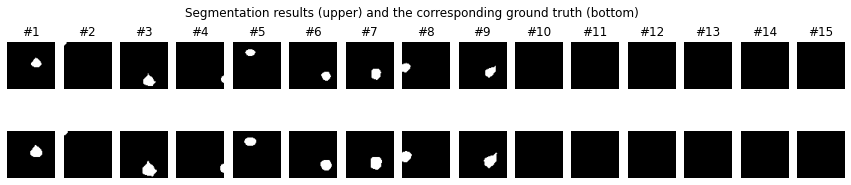

Text(0.5, 0.98, 'Traces results')

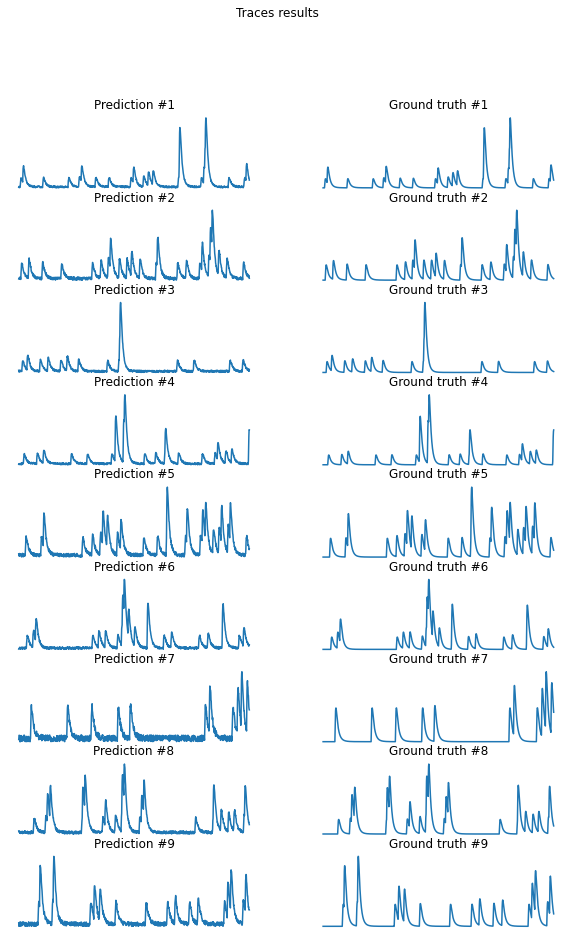

In [31]:
video_test = sio.loadmat("Video_test.mat")
video_test = video_test['LSTM_video']
seg_GT = sio.loadmat("Masks_test.mat")
seg_GT = seg_GT(['LSTM_mask'])
trace_GT = sio.loadmat("Masks_test.mat")
trace_GT = trace_GT(['LSTM_trace'])

model_seg = load_model('LSTM_seg.h5')
model_trace = load_model('LSTM_ISTAnet.h5')
seg_red = model_seg.predict_on_batch(video_test)
trace_pred = model_trace.predict_on_batch(video_test)

plt.figure(figsize=(15,3))
for i in range(15):
    plt.subplot(2,15,i+1)
    plt.imshow(seg_pred[:,:,i],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')
    plt.title('#'+str(i+1))
    plt.subplot(2,15,i+16)
    plt.imshow(seg_GT[i,:,:],vmin=0,vmax=1,cmap='gray')
    plt.axis('off')
plt.suptitle('Segmentation results (upper) and the corresponding ground truth (bottom)')
plt.show()

plt.figure(figsize=(15, 15))
for i in range(9):
    
    plt.subplot(9,2,2*i+1)
    plt.title('Prediction #'+str(i+1))
    plt.plot(trace_pred[i,:]+np.random.uniform(0,0.1,1000))
    plt.axis('off')                
    plt.subplot(9,2,2*i+2)
    plt.title('Ground truth #'+str(i+1))
    plt.plot(trace_GT[i,:])
    plt.axis('off')
plt.suptitle('Traces results')